# NBA Game Prediction

## Import Statements

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import csv
import random
import numpy as np
import pickle
import graphviz
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import linear_model 
from sklearn.model_selection import train_test_split,cross_val_score # Cross validation and parameter selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os

## Subfunction Definition

In [ ]:
# Initialize according to the statistics in the CSV file
def initialize_data(Mstat, Ostat, Tstat):
    # Delete the corresponding data column using drop()
    new_Mstat = Mstat.drop(['Rk', 'Arena'], axis=1)
    new_Ostat = Ostat.drop(['Rk', 'G', 'MP'], axis=1)
    new_Tstat = Tstat.drop(['Rk', 'G', 'MP'], axis=1)
    
    # Concatenate the three tables according to the team name property
    team_stats1 = pd.merge(new_Mstat, new_Ostat, how='left', on='Team') 
    team_stats1 = pd.merge(team_stats1, new_Tstat, how='left', on='Team')
    
    # Return the concatenated table with the team name as the index for the new table
    return team_stats1.set_index('Team', inplace=False, drop=True)

In [ ]:
# Returns the ELO value for each team
def get_elo(team):
    try:
        return team_elos[team] 
    except:
        # When there is no ELO initially, each team is assigned initial base_ELO
        team_elos[team] = base_elo
        return team_elos[team]

In [ ]:
# Calculate the ELO value for each team based on the rating
def calc_elo(win_team, lose_team):
    # print("Calculating elo...")
    winner_rank = get_elo(win_team) # ELO of the winning team
    loser_rank = get_elo(lose_team) # ELO of the losing team
    rank_diff = winner_rank - loser_rank # The difference of ELO between two teams
    exp = (rank_diff  * -1) / 400  # Get the exponent of the LD formula
    odds = 1 / (1 + math.pow(10, exp))  # Logistic Distribution
    
    # Change the K value based on rank levels
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    
    # Update the value of rank
    new_winner_rank = round(winner_rank + (k * (1 - odds)))      
    new_loser_rank = round(loser_rank + (k * (0 - odds)))
    return new_winner_rank, new_loser_rank

In [ ]:
# Based on the statistical data and the ELO score of each team, the data set corresponding to each regular season and playoff game was established
def build_dataSet(all_data):
    # print("Building data set...")
    X = []
    Y = []
    skip = 0
    
    # traverse every game
    for index, row in all_data.iterrows():
        # Gets the names of the teams on both sides of the match
        Wteam = row['WTeam'] 
        Lteam = row['LTeam'] 

        # Gets the initial ELO value for each team
        team1_elo = get_elo(Wteam) 
        team2_elo = get_elo(Lteam)

        # Add 100 ELO to the team playing at home
        if row['WLoc'] == 'H':
            team1_elo += 100
        else:
            team2_elo += 100

        # Elo was taken as the first eigenvalue to evaluate each team, and the corresponding eigenvector was constructed
        team1_features = [team1_elo] 
        team2_features = [team2_elo] 

        # Add the statistics we obtained from Basketball Reference.com for each team to form sample X
        for key, value in team_stats.loc[Wteam].iteritems():
            team1_features.append(value)
        for key, value in team_stats.loc[Lteam].iteritems():
            team2_features.append(value)

        # The eigenvalues of the two teams are randomly assigned to the left and right sides of each match data, and the corresponding 0/1(label) is assigned to the y value
        if random.random() > 0.5:
            X.append(team1_features + team2_features)
            Y.append(0)
        else:
            X.append(team2_features + team1_features)
            Y.append(1)
        
        if skip == 0:
            skip = 1

        # Update your team's ELO score based on this match
        new_winner_rank, new_loser_rank = calc_elo(Wteam, Lteam)
        team_elos[Wteam] = new_winner_rank
        team_elos[Lteam] = new_loser_rank 
    
    # Convert nan and INF elements in the Numpy array to the corresponding values
    return np.nan_to_num(X), Y 

In [ ]:
# A function that predicts the winning side
def predict_winner(team_1, team_2, model):
    # print("Predicting winner...")
    features = []

    # team_1，the away team
    features.append(get_elo(team_1))
    for key, value in team_stats.loc[team_1].iteritems():
        features.append(value)

    # team_2，the host team
    features.append(get_elo(team_2) + 100)
    for key, value in team_stats.loc[team_2].iteritems():
        features.append(value)

    features = np.nan_to_num(features)
    return model.predict_proba([features])

## Load Data

In [ ]:
# Set parameters for regression training: When each team does not have an ELO rating, assign it a basic ELO rating
base_elo = 1600
team_elos = {} 
team_stats = {}
X = []
Y = []
folder = './date'

In [ ]:
if __name__ == '__main__':
    # Team statistics
    Mstat = pd.read_csv("./18-19Miscellaneous_Stat.csv")
    Ostat = pd.read_csv("./18-19Oppoent_Per_Game_Stat.csv")
    Tstat = pd.read_csv("./18-19Team Per Game Stats.csv")
    team_stats = initialize_data(Mstat, Ostat, Tstat) 
    
    # Match result data
    result_data = pd.read_csv("2018-2019_result.csv") 
    
    # Building a data set
    X, Y = build_dataSet(result_data) 

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X, Y, test_size=1/3, random_state=3)
print(type(X))
print(type(Y))
print(train_X.shape)
print(test_X.shape)
print(len(train_Y))
print(len(test_Y))

<class 'numpy.ndarray'>
<class 'list'>
(820, 136)
(410, 136)
820
410


## Find Correlations

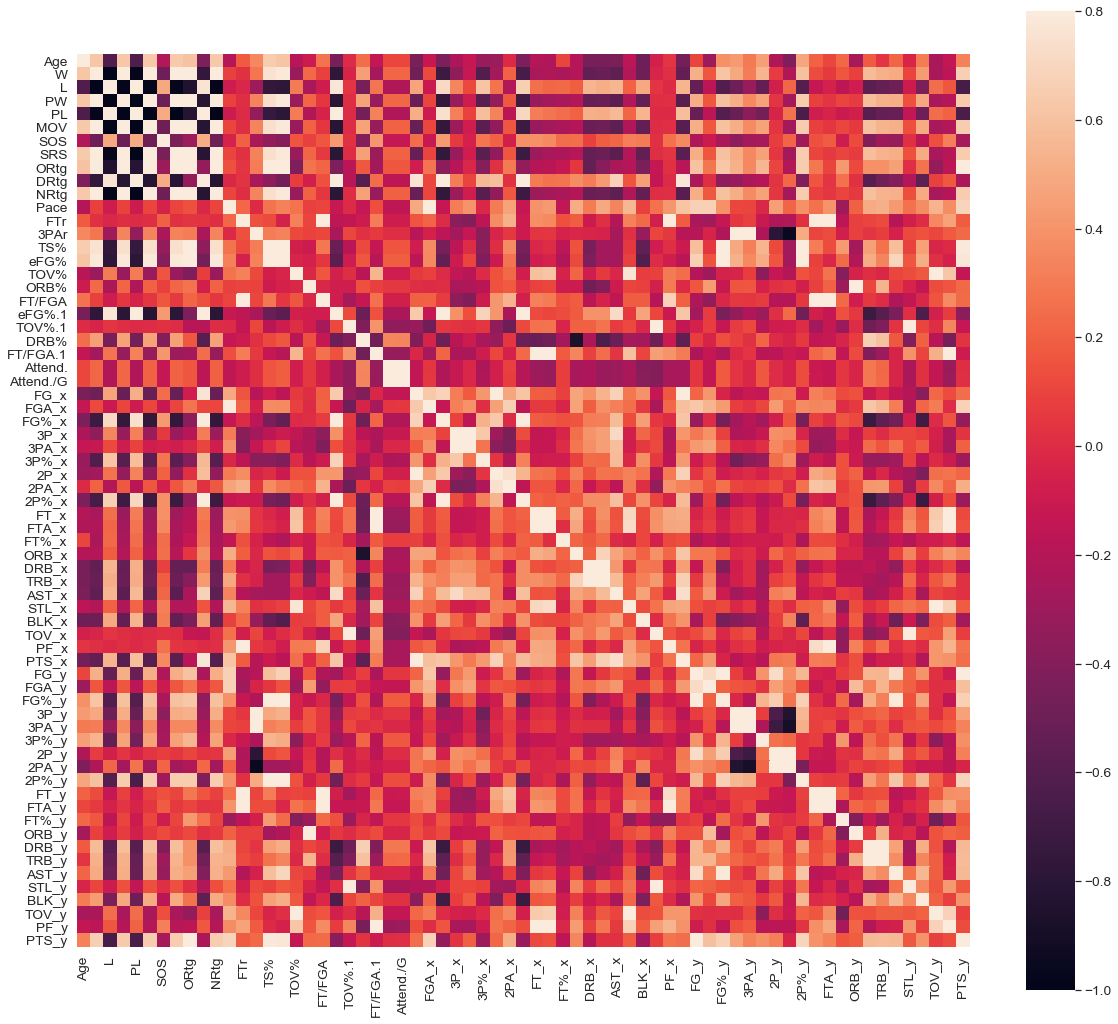

In [ ]:
# correlation matrix
corrmat = team_stats.corr() #
fig, ax = plt.subplots(figsize=(20,18)) 
sns.heatmap(corrmat, vmax=.8, square=True)

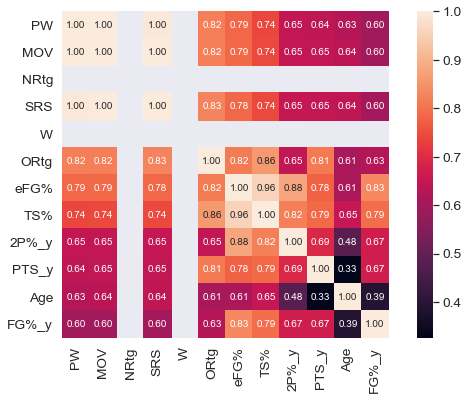

In [ ]:
# Target variable: PW (Pythagorean WINS) -- The probability of winning calculated based on Pythagorean theory
k = 12 
cols = corrmat.nlargest(k, 'PW')['PW'].index 
# Pandas. Nlarge () is the output maximum correlation sort, and the index of the PW column is selected after the sorting
f, ax = plt.subplots(figsize=(10,6)) 
cm = np.corrcoef(team_stats[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values) 
# Annot Displays the relevant degree number
plt.show()

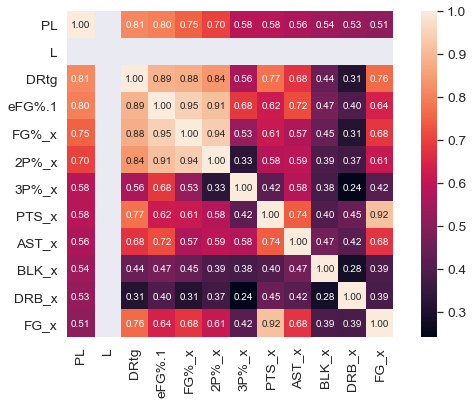

In [ ]:
# Target variable: PL (Pythagorean Losses) -- The probability of losing calculated based on Pythagorean theory
k = 12
cols = corrmat.nlargest(k, 'PL')['PL'].index
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(team_stats[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

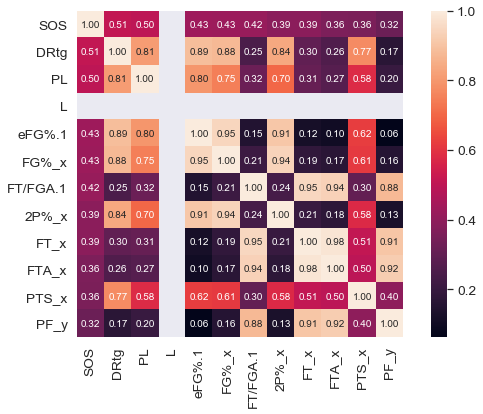

In [ ]:
# Target variable: SOS (Strength of Schedule) -- Used to evaluate the difficulty of an opponent's selection against his team or other teams.
# 0 is the average line, which can be positive or negative
k = 12
cols = corrmat.nlargest(k, 'SOS')['SOS'].index
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(team_stats[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

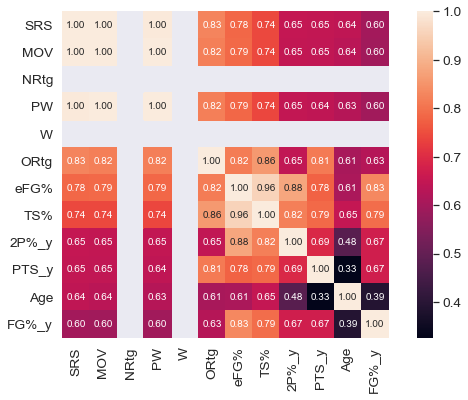

In [ ]:
# Target variable: SRS (Simple Rating System) -- A Simple Rating System that ranks teams according to their points difference
k = 12
cols = corrmat.nlargest(k, 'SRS')['SRS'].index
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(team_stats[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

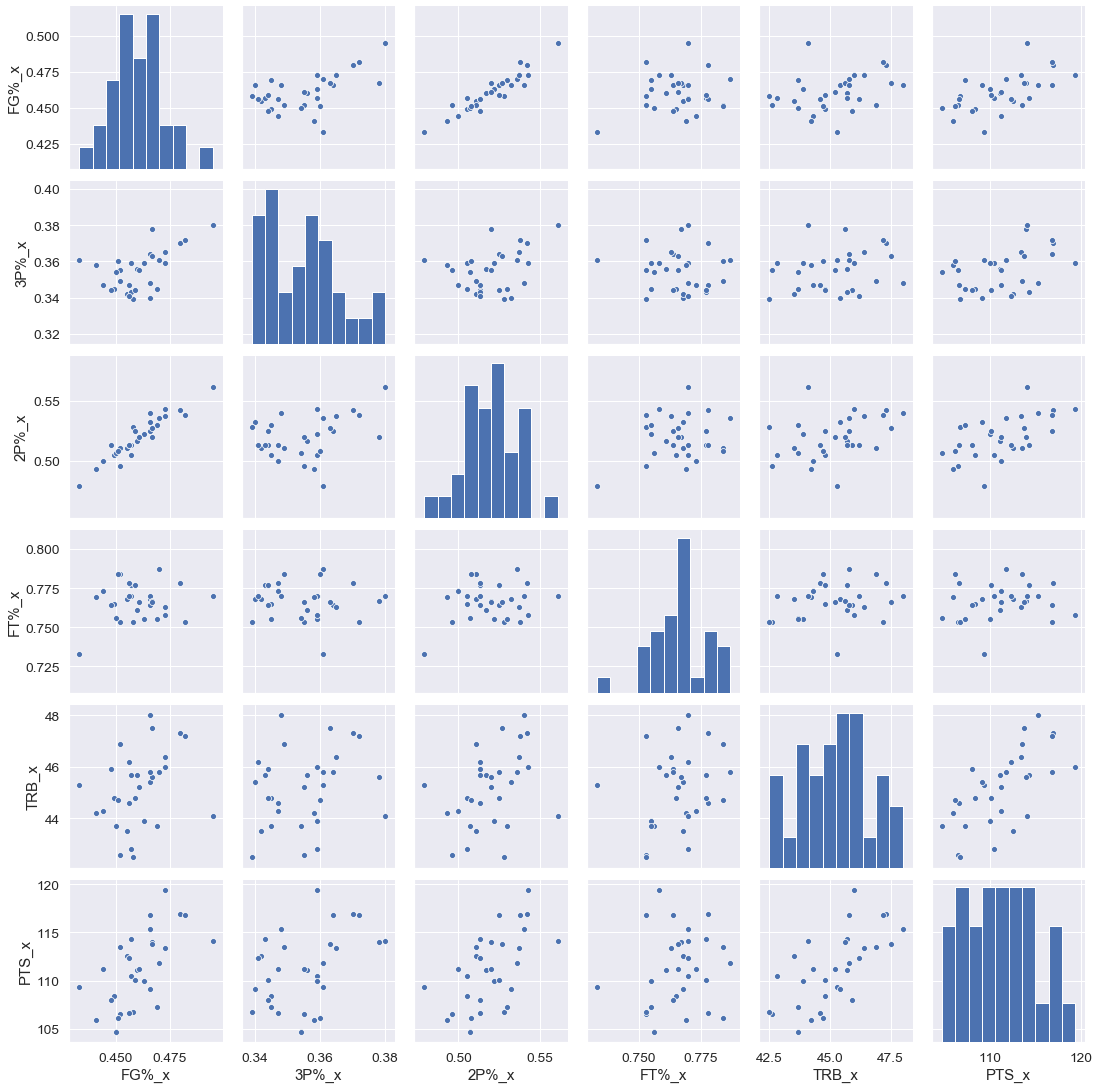

In [ ]:
# scatter plots of team_stats
cols1 = ['FG%_x','3P%_x','2P%_x','FT%_x','TRB_x','PTS_x']
sns.pairplot(team_stats[cols1], height=2.5)
plt.show()

## Prepare Data 

In [ ]:
# fetch the result of season 18-19
result = result_data[['Visitor/Neutral','Home/Neutral','WLoc']] # Put together the teams and results for each match

In [ ]:
# load data
Mstat1 = pd.read_csv("./18-19Miscellaneous_Stat.csv")#load 18-19Miscellaneous_Stat data into Mstat1
Ostat1 = pd.read_csv("./18-19Oppoent_Per_Game_Stat.csv")#load 18-19Oppoent_Per_Game_Stat data into Ostat1
Tstat1 = pd.read_csv("./18-19Team Per Game Stats.csv")#load 18-19Team Per Game Stats into Tstat1
team_stats1 = pd.merge(Mstat1, Ostat1, how='left', on='Team') 
team_stats1 = pd.merge(team_stats1, Tstat1, how='left', on='Team')
ts = team_stats1[['Team','PW','PL']] # Put together PW and PL information for each team

In [ ]:
# prepare x and y
x = pd.DataFrame()
y = pd.DataFrame()
features_cols = ['PW','PL']
for index, game in result.iterrows():
    visitor = game['Visitor/Neutral']
    home = game['Home/Neutral']
    
    # Statistics are obtained for each match against each other
    for index, f in ts.iterrows():
        if f['Team'] == visitor:
            visitor_feature = f[features_cols]
        if f['Team'] == home:
            home_feature = f[features_cols]
    
    # Build dataframes based on the statistics of the two teams
    df_x = pd.DataFrame([{'PW_v':visitor_feature['PW'],
                        'PL_v':visitor_feature['PL'],
                        'PW_h':home_feature['PW'],
                        'PL_h':home_feature['PL']
                       }])
    
    # Put together the statistics for each match
    x = x.append(df_x)
    
    r = 1 if game['WLoc'] == 'H' else 0
    df_y = pd.DataFrame([{'WLoc':r}])
    y = y.append(df_y)

x = x.reset_index(drop=True) 
y = y.reset_index(drop=True)

In [ ]:
# train test split, standardize data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(738, 4)
(492, 4)
(738, 1)
(492, 1)


## Prediction Models

In [ ]:
# Logistic Regression
LR = linear_model.LogisticRegression()
LR.fit(train_X, train_Y)
pred = LR.predict(test_X)
model = LR

print(LR.predict_proba(test_X))
print(metrics.accuracy_score(test_Y, pred))

# The training accuracy was calculated by 10 fold cross validation
print("Doing cross-validation..")
# scores = cross_val_score(LR, train_X, train_Y, cv = 10, scoring='accuracy', n_jobs=-1)
# print(scores.mean())

[[0.79284272 0.20715728]
 [0.3508227  0.6491773 ]
 [0.50027527 0.49972473]
 [0.22082692 0.77917308]
 [0.68438145 0.31561855]
 [0.19388311 0.80611689]
 [0.13393042 0.86606958]
 [0.54334492 0.45665508]
 [0.49780198 0.50219802]
 [0.15535785 0.84464215]
 [0.8037577  0.1962423 ]
 [0.3561598  0.6438402 ]
 [0.78644755 0.21355245]
 [0.38703495 0.61296505]
 [0.66115352 0.33884648]
 [0.37631507 0.62368493]
 [0.20154856 0.79845144]
 [0.42379145 0.57620855]
 [0.61324532 0.38675468]
 [0.56782496 0.43217504]
 [0.76802219 0.23197781]
 [0.58547774 0.41452226]
 [0.79527436 0.20472564]
 [0.71844605 0.28155395]
 [0.63193257 0.36806743]
 [0.32283075 0.67716925]
 [0.82267038 0.17732962]
 [0.6991785  0.3008215 ]
 [0.6081104  0.3918896 ]
 [0.19949925 0.80050075]
 [0.24714396 0.75285604]
 [0.58690947 0.41309053]
 [0.39672042 0.60327958]
 [0.32235688 0.67764312]
 [0.40488384 0.59511616]
 [0.34375082 0.65624918]
 [0.47190164 0.52809836]
 [0.59332164 0.40667836]
 [0.62943802 0.37056198]
 [0.33482317 0.66517683]


In [ ]:
# KNN
cv_scores = []
k_range = range(1,31)
for n in k_range:
    knn = KNeighborsClassifier(n)
    scores = cross_val_score(knn,train_X,train_Y,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())
    print(scores.mean())

0.5439024390243903
0.5475609756097561
0.5719512195121952
0.5365853658536587
0.5707317073170731
0.5609756097560976
0.5634146341463415
0.5560975609756099
0.5731707317073171
0.5585365853658536
0.5829268292682928
0.5621951219512196
0.575609756097561
0.5768292682926829
0.576829268292683
0.5817073170731707
0.5829268292682928
0.5804878048780489
0.5707317073170732
0.5902439024390245
0.5902439024390244
0.5890243902439025
0.5780487804878048
0.5768292682926829
0.5658536585365853
0.5841463414634147
0.5792682926829268
0.5853658536585366
0.5841463414634146
0.5878048780487805


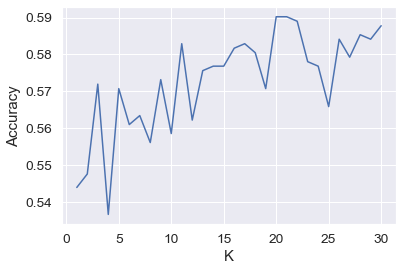

In [ ]:
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=23)
best_knn.fit(train_X,train_Y)
best_pred = best_knn.predict(test_X)

print(best_knn.predict_proba(test_X))
print(metrics.accuracy_score(test_Y, best_pred))

[[0.52173913 0.47826087]
 [0.39130435 0.60869565]
 [0.47826087 0.52173913]
 [0.43478261 0.56521739]
 [0.73913043 0.26086957]
 [0.30434783 0.69565217]
 [0.34782609 0.65217391]
 [0.30434783 0.69565217]
 [0.34782609 0.65217391]
 [0.26086957 0.73913043]
 [0.52173913 0.47826087]
 [0.34782609 0.65217391]
 [0.43478261 0.56521739]
 [0.47826087 0.52173913]
 [0.47826087 0.52173913]
 [0.56521739 0.43478261]
 [0.34782609 0.65217391]
 [0.2173913  0.7826087 ]
 [0.39130435 0.60869565]
 [0.47826087 0.52173913]
 [0.47826087 0.52173913]
 [0.43478261 0.56521739]
 [0.7826087  0.2173913 ]
 [0.52173913 0.47826087]
 [0.52173913 0.47826087]
 [0.43478261 0.56521739]
 [0.39130435 0.60869565]
 [0.52173913 0.47826087]
 [0.30434783 0.69565217]
 [0.26086957 0.73913043]
 [0.39130435 0.60869565]
 [0.39130435 0.60869565]
 [0.39130435 0.60869565]
 [0.43478261 0.56521739]
 [0.43478261 0.56521739]
 [0.13043478 0.86956522]
 [0.39130435 0.60869565]
 [0.56521739 0.43478261]
 [0.39130435 0.60869565]
 [0.47826087 0.52173913]


In [ ]:
# Logistic Regression
LR = linear_model.LogisticRegression()
LR.fit(x_train, y_train)
pred = LR.predict(x_test)

print(LR.predict_proba(x_test))
print(metrics.accuracy_score(y_test, pred))

[[0.1422233  0.8577767 ]
 [0.32560621 0.67439379]
 [0.23649319 0.76350681]
 [0.4384635  0.5615365 ]
 [0.48085443 0.51914557]
 [0.13159612 0.86840388]
 [0.5179203  0.4820797 ]
 [0.24207705 0.75792295]
 [0.74360269 0.25639731]
 [0.62370494 0.37629506]
 [0.40382305 0.59617695]
 [0.69517293 0.30482707]
 [0.54209912 0.45790088]
 [0.71951773 0.28048227]
 [0.3974447  0.6025553 ]
 [0.3813909  0.6186091 ]
 [0.19456856 0.80543144]
 [0.14961186 0.85038814]
 [0.71515641 0.28484359]
 [0.36511514 0.63488486]
 [0.23189774 0.76810226]
 [0.23063366 0.76936634]
 [0.5880798  0.4119202 ]
 [0.17919782 0.82080218]
 [0.40603202 0.59396798]
 [0.58857801 0.41142199]
 [0.48085443 0.51914557]
 [0.27990731 0.72009269]
 [0.27990731 0.72009269]
 [0.54896183 0.45103817]
 [0.33374898 0.66625102]
 [0.71868671 0.28131329]
 [0.1073486  0.8926514 ]
 [0.21730705 0.78269295]
 [0.63374645 0.36625355]
 [0.50488117 0.49511883]
 [0.37584652 0.62415348]
 [0.52557489 0.47442511]
 [0.15263503 0.84736497]
 [0.68754907 0.31245093]


In [ ]:
# knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

print(knn.predict_proba(x_test))
print(metrics.accuracy_score(y_test, pred))

[[0.  1. ]
 [0.4 0.6]
 [0.  1. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.  1. ]
 [0.2 0.8]
 [0.6 0.4]
 [0.8 0.2]
 [0.4 0.6]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.8 0.2]
 [0.6 0.4]
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]
 [0.8 0.2]
 [0.4 0.6]
 [0.  1. ]
 [0.2 0.8]
 [0.6 0.4]
 [0.  1. ]
 [0.6 0.4]
 [0.8 0.2]
 [0.4 0.6]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.8 0.2]
 [0.  1. ]
 [0.  1. ]
 [1.  0. ]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.4 0.6]
 [0.8 0.2]
 [0.2 0.8]
 [0.2 0.8]
 [0.4 0.6]
 [0.  1. ]
 [0.2 0.8]
 [0.8 0.2]
 [0.2 0.8]
 [0.4 0.6]
 [0.2 0.8]
 [0.8 0.2]
 [0.8 0.2]
 [0.4 0.6]
 [1.  0. ]
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]
 [0.6 0.4]
 [0.  1. ]
 [0.2 0.8]
 [0.  1. ]
 [0.  1. ]
 [0.4 0.6]
 [0.  1. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.4 0.6]
 [0.8 0.2]
 [0.2 0.8]
 [0.2 0.8]
 [0.8 0.2]
 [0.4 0.6]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]
 [0.6 0.4]
 [0.6 0.4]
 [0.2 0.8]
 [0.2 0.8]
 [1.  0. ]
 [0.  1. ]
 [0.4 0.6]
 [0.2 0.8]
 [0.6 0.4]
 [0.6 0.4]
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]
 [0.2 0.8]
 [0.2 0.8]

In [ ]:
# Linear SVM
clf = LinearSVC(random_state=2)
clf.fit(x_train, y_train)
pred = (clf.predict(x_test))

print(clf.coef_)
print(clf.intercept_)
print(metrics.accuracy_score(y_test, pred))

[[ 0.00273449  0.01025499  0.01672108 -0.0037316 ]]
[0.00015841]
0.6016260162601627


In [ ]:
# Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

print(clf.feature_importances_)
print(clf.predict_proba(x_test))
print(metrics.accuracy_score(y_test, pred))

[0.24283659 0.25511598 0.23744684 0.26460059]
[[0.04583333 0.95416667]
 [0.71466667 0.28533333]
 [0.         1.        ]
 [0.47433333 0.52566667]
 [0.22441087 0.77558913]
 [0.05097294 0.94902706]
 [0.1517381  0.8482619 ]
 [0.51723485 0.48276515]
 [0.6590754  0.3409246 ]
 [0.51888889 0.48111111]
 [0.16591667 0.83408333]
 [0.56414668 0.43585332]
 [0.63781349 0.36218651]
 [0.90833333 0.09166667]
 [0.77666667 0.22333333]
 [0.07116667 0.92883333]
 [0.         1.        ]
 [0.         1.        ]
 [0.84364888 0.15635112]
 [0.14354762 0.85645238]
 [0.04285714 0.95714286]
 [0.1130656  0.8869344 ]
 [0.85099459 0.14900541]
 [0.27971898 0.72028102]
 [0.50005189 0.49994811]
 [0.30483333 0.69516667]
 [0.22441087 0.77558913]
 [0.08583333 0.91416667]
 [0.08583333 0.91416667]
 [0.1760406  0.8239594 ]
 [0.76528571 0.23471429]
 [0.97166667 0.02833333]
 [0.00333333 0.99666667]
 [0.         1.        ]
 [1.         0.        ]
 [0.80641667 0.19358333]
 [0.69780464 0.30219536]
 [0.19416667 0.80583333]
 [0.

In [ ]:
# Gradient Tree Boosting
clfgtb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
print(clfgtb.score(x_test, y_test))

0.6707317073170732


## Predict Result

In [ ]:
# Use trained models to make predictions over 19-20 years of competition
print('Predicting on new schedule..')
schedule19_20 = pd.read_csv("19-20Schedule.csv")
result = []
for index, row in schedule19_20.iterrows():
    team1 = row['Vteam'] 
    team2 = row['Hteam'] 
    pred = predict_winner(team1, team2, model) # Predict the winner
    prob = pred[0][0] # Obtaining forecast results
    
    # Record forecast results
    if prob > 0.5: # The away team wins
        winner = team1
        loser = team2
        result.append([winner, loser, prob])
    else: # The host team wins
        winner = team2
        loser = team1
        result.append([winner, loser, 1 - prob])

Predicting on new schedule..


In [ ]:
# Save forecast results
with open('19-20Result.csv', 'w') as f: 
    writer = csv.writer(f)
    writer.writerow(['win', 'lose', 'probability'])
    writer.writerows(result)
    print('done.')

done.


In [ ]:
# Reading prediction results
pd.read_csv('19-20Result.csv',header=0)

,win,lose,probability
0,Toronto Raptors,New Orleans Pelicans,0.858916
1,Los Angeles Clippers,Los Angeles Lakers,0.664106
2,Charlotte Hornets,Chicago Bulls,0.813653
3,Indiana Pacers,Detroit Pistons,0.651846
4,Orlando Magic,Cleveland Cavaliers,0.918165
...,...,...,...
1225,San Antonio Spurs,New Orleans Pelicans,0.753898
1226,Indiana Pacers,Washington Wizards,0.661648
1227,Los Angeles Lakers,Phoenix Suns,0.856649
1228,Portland Trail Blazers,Los Angeles Clippers,0.691291


In [ ]:
def build_dataSet(all_data):
    print("Building data set..")
    X = []
    y = []
    skip = 0
    for index, row in all_data.iterrows():
        Wteam = row['WTeam']
        Lteam = row['LTeam']

        # Gets the initial ELO value for each team
        team1_elo = get_elo(Wteam) 
        team2_elo = get_elo(Lteam) #

        # Add 100 ELO to the team playing at home
        if row['WLoc'] == 'H':
            team1_elo += 100
        else:
            team2_elo += 100

        # Consider ELO as the first eigenvalue for evaluating each team
        team1_features = [team1_elo]
        team2_features = [team2_elo]

        # Add the stats we got from Basketball Reference.com for each team
        for key, value in team_stats.loc[Wteam].iteritems():
            team1_features.append(value)
        for key, value in team_stats.loc[Lteam].iteritems():
            team2_features.append(value)

        # The eigenvalues of the two teams are randomly assigned to the left and right sides of each match data, and the corresponding 0/1 is assigned to the y value
        if random.random() > 0.5:
            X.append(team1_features + team2_features)
            y.append(0)
        else:
            X.append(team2_features + team1_features)
            y.append(1)

        if skip == 0:
            skip = 1

        # Update your team's ELO score based on this match
        new_winner_rank, new_loser_rank = calc_elo(Wteam, Lteam)
        team_elos[Wteam] = new_winner_rank
        team_elos[Lteam] = new_loser_rank

    return np.nan_to_num(X), y 

In [ ]:
# RNN——LSTM
class SentimentRNN(nn.Module):
    # RNN initialization function:
    # self is only needed in a function of a class, pointing to an instance of the class
    # batch_size indicates the size of each batch, that is, the number of samples counted simultaneously in each time_step
    # embedding_size denotes the dimension of the word vector (equivalent to input_size: the characteristic dimension of the input data)
    # output_size indicates the number of expected features in the output Oi
    # hidden_DIM indicates the number/dimension of neurons in the hidden layer
    # n_layers indicates the number of hidden layers
    # DROP_PROb represents the discarding probability of neurons in the hidden layer to ensure that the calculation results of the output layer will not be overly dependent on a node and prevent over-fitting
    def __init__(self, batch_size, embedding_size, output_size, hidden_dim, n_layers, drop_prob=0.5): 
        super(SentimentRNN, self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # define the layers of the model
        # LSTM/LSTM layers
        # embedding_size/input_size: The input characteristic dimension, which is the number of elements in each one-dimensional vector
        # hidden_DIM /hidden_size: dimension of the hidden layer/number of nodes. The specific value depends on service requirements
        # n_layers/num_layers: the number of layers stacked in LSTM. Each layer receives the output of the previous layer and continues the calculation
        # drop_out: Add dropout layer after all RNN layers except the last RNN layer
        # batCH_first: Used to tell whether the batch data in LSTM has the same meaning as the batch data in data loader
        self.lstm = nn.LSTM(embedding_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # dropout layer to avoida over fitting
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        
        # Sigmoid(x)=1/[1+exp(-x)]
        self.sig = nn.Sigmoid()
        
    # forward pass through the network
    def forward(self, x, hidden):
        batch_size = 1 
        
        # get the outputs and the new hidden state from the lstm
        lstm_out, hidden = self.lstm(x, hidden)
        
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        
        # get last batch of labels
        sig_out = sig_out[:, -1]
        
        # return the final output and the hidden state
        return sig_out,hidden 
        
    # initialize hidden state
    def init_hidden(self):
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_())
        return hidden

In [ ]:
if __name__ == '__main__':
    # load data
    Mstat = pd.read_csv(r'15-16Miscellaneous_Stat.csv')
    Ostat = pd.read_csv(r'15-16Opponent_Per_Game_Stat.csv')
    Tstat = pd.read_csv(r'15-16Team_Per_Game_Stat.csv')
    team_stats = initialize_data(Mstat, Ostat, Tstat)
    result_data = pd.read_csv(r'2015-2016_result.csv')
    
    # prepare data
    D, Y = build_dataSet(result_data)
    x = np.zeros((len(D), 1, 132)) #zeros(shape, dtype=float, order=‘C’)
    for i in range(0, len(D)):
        x[i, 0] = D[i] 
    y = np.zeros((len(Y), 1, 1))
    for i in range(0, len(Y)):
        y[i] = Y[i] 
    
    # Tensor() is used to generate new tensors, which calls the Tensor constructor __init__ of the Tensor class to generate tensors of single-precision floating-point type
    # Dataset is a wrapper class that wraps data as a Dataset class and passes it into the DataLoader
    # Shuffle indicates the shuffling operation, batch_size indicates the size of each batch (where the number of samples read ata time is 1), num_workers indicates how many sub-processes are used to load data
    train_data = TensorDataset(torch.Tensor(x), torch.Tensor(y))
    train_loader = DataLoader(train_data, shuffle=True, batch_size=1, num_workers=5)

    # construct RNN
    batch_size = 1
    embedding_size = 132
    output_size = 1
    hidden_dim = 256
    n_layers = 3
    net = SentimentRNN(batch_size, embedding_size, output_size, hidden_dim, n_layers)
    
    # The neural network optimizer -- Stochastic Gradient Descent is used to accelerate the neural network training process
    # Create an optimizer object that provides arguments of Variable type for optimization and specifies the learning rate and other parameters
    # When we use SGD, we will split the data and then batch it into NN continuously for calculation. Use batch data each time
    # The learning rate is small and the speed of convergence to the extreme value is slow; Learning rate is large, easy to oscillate in the process of search
    optimizer = torch.optim.SGD(net.parameters(), lr=0.02) 
    
    loss_func = torch.nn.BCELoss()
    
    h = net.init_hidden()
    
    for inputs, labels in train_loader: 
        h = tuple([each.data for each in h])
        # zero accumulated gradients
        net.zero_grad() # By setting the gradient to zero, the derivative of Loss with respect to weight becomes 0.
        out, h = net(inputs, h)  # Feed net training data X, output analysis value (use forward propagation forward function to calculate the predicted value)
        loss = loss_func(out.squeeze(), labels.float())  # Calculate the error loss of both
        loss.backward()  # Error backpropagation, calculate parameter update value (backpropagation for gradient)
        optimizer.step()  # Apply the updated value to net parameters (update all parameters) 

Building data set..


In [ ]:
print('Predicting on new schedule..')
h = net.init_hidden() # Initialize the hidden layer
net.eval()

schedule1920 = pd.read_csv(r'19-20Schedule.csv')
result = []
for index, row in schedule1920.iterrows():
    team1 = row['Vteam']
    team2 = row['Hteam']
    features = []
    
    # team 1，away team
    features.append(get_elo(team1))
    for key, value in team_stats.loc[team1].iteritems():
        features.append(value)
        
    # team 2，host team
    features.append(get_elo(team2) + 100)
    for key, value in team_stats.loc[team2].iteritems():
        features.append(value)
        
    features = np.nan_to_num(features)
    pred = np.zeros((1, 1, 132))
    pred[0] = features
    pred = torch.from_numpy(pred)
    pred = pred.float()
    # print(type(pred))
    prob,h = net(pred,h)
    if prob > 0.5:
        winner = team1
        loser = team2
        result.append([winner, loser, prob])
    else:
        winner = team2
        loser = team1
        result.append([winner, loser, 1 - prob])

In [ ]:
# save result
with open('19-20Result_LSTM.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['win', 'lose', 'probability'])
    writer.writerows(result) # Predictions for each race
    print('done.')